In [1]:
from finta import TA

import pandas as pd
import yfinance as yf
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily
from functools import reduce

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10



from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('once')



In [2]:
data = pd.read_csv('/Users/benitorusconi/Documents/CDS/06_FS24/DataScienceBanking/S_P_500_Prediction/data/sp500_stocks.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#sort by Date
data.sort_values(by='Date', inplace=True)
#add 25 and 50 rolling avergaed of close by Symbol
data['5ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=5).mean()
data['25ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=25).mean()
data['50ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=50).mean()
data['100ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=100).mean()  
data['200ma'] = data.groupby('Symbol')['Close'].shift().rolling(window=200).mean()


#drop rows with NaN

data.tail()

#set frequency to daily




,Symbol,Adj Close,Close,High,Low,Open,Volume,5ma,25ma,50ma,100ma,200ma
Date,,,,,,,,,,,,
2024-03-18,LW,102.860001,102.860001,103.570000,100.559998,101.599998,1242540.0,272.534000,206.190803,180.387401,170.649901,186.52080
2024-03-18,GD,277.600006,277.600006,277.720001,274.670013,275.989990,850451.0,321.097998,214.685203,183.910201,173.198601,187.49295
2024-03-18,HAS,53.290001,53.290001,53.466000,52.959999,53.250000,1173531.0,273.956001,206.531603,181.980401,173.388401,185.99835
2024-03-18,CTVA,54.709999,54.709999,55.450001,54.520000,55.450001,2943730.0,190.780000,193.399603,180.014801,172.464501,185.94265
2024-03-18,ZTS,170.690002,170.690002,174.279999,170.410004,173.740005,4919422.0,131.648000,194.271603,180.708202,172.912901,186.22535


In [3]:


# Assuming 'data' is your DataFrame
# Ensure your DataFrame is sorted by 'Date' if it's not already
data.sort_values(by=['Date'], inplace=True)

# Placeholder DataFrame to hold the results
result_data = pd.DataFrame()

for symbol in data['Symbol'].unique():
    # Filter the DataFrame for the current symbol
    stock_data = data[data['Symbol'] == symbol]
    
    # Calculate the SMA for the filtered DataFrame
    # Here, we are calculating a 20-day SMA of the 'Close' price
    stock_data['RSI'] = TA.RSI(stock_data)
    stock_data['ATR'] = TA.ATR(stock_data)
    stock_data['BBWIDTH'] = TA.BBWIDTH(stock_data)
    stock_data['WilliamsR'] = TA.WILLIAMS(stock_data)
    
    # Append the results to the result_data
    result_data = pd.concat([result_data, stock_data])

# Optionally, you might want to sort the result_data by 'Date' and 'Symbol' again
result_data.sort_values(by=['Date', 'Symbol'], inplace=True)

data = result_data
# result_data now contains your original data along with the new 20d_SMA indicator for each stock


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
data.dropna(subset=['Close','5ma', '25ma', '50ma', '100ma', '200ma', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR'], inplace=True)
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(len(data))
print(data.info())

Number of rows with missing values: 0.9105289938689541
Number of rows with missing values: 0.0
Number of rows with missing values: 0.0
160889
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160889 entries, 2016-06-16 to 2024-03-18
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Symbol     160889 non-null  object 
 1   Adj Close  160889 non-null  float64
 2   Close      160889 non-null  float64
 3   High       160889 non-null  float64
 4   Low        160889 non-null  float64
 5   Open       160889 non-null  float64
 6   Volume     160889 non-null  float64
 7   5ma        160889 non-null  float64
 8   25ma       160889 non-null  float64
 9   50ma       160889 non-null  float64
 10  100ma      160889 non-null  float64
 11  200ma      160889 non-null  float64
 12  RSI        160889 non-null  float64
 13  ATR        160889 non-null  float64
 14  BBWIDTH    160889 non-null  float64
 15  WilliamsR  160889 non-null  f

Train error: 47.05961541860775
Test error: 73.4600939552856


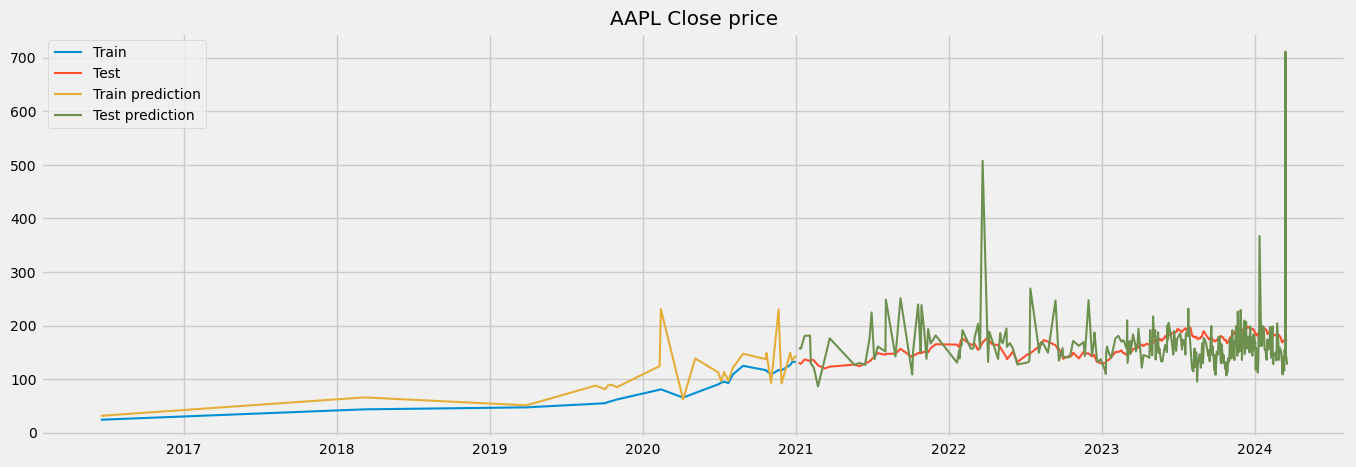

In [5]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
#convert Date to index
#data.set_index('Date', inplace=True)

data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = Ridge()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


# SGQRegressor

Train error: 46.674229612269244
Test error: 70.05597291019532


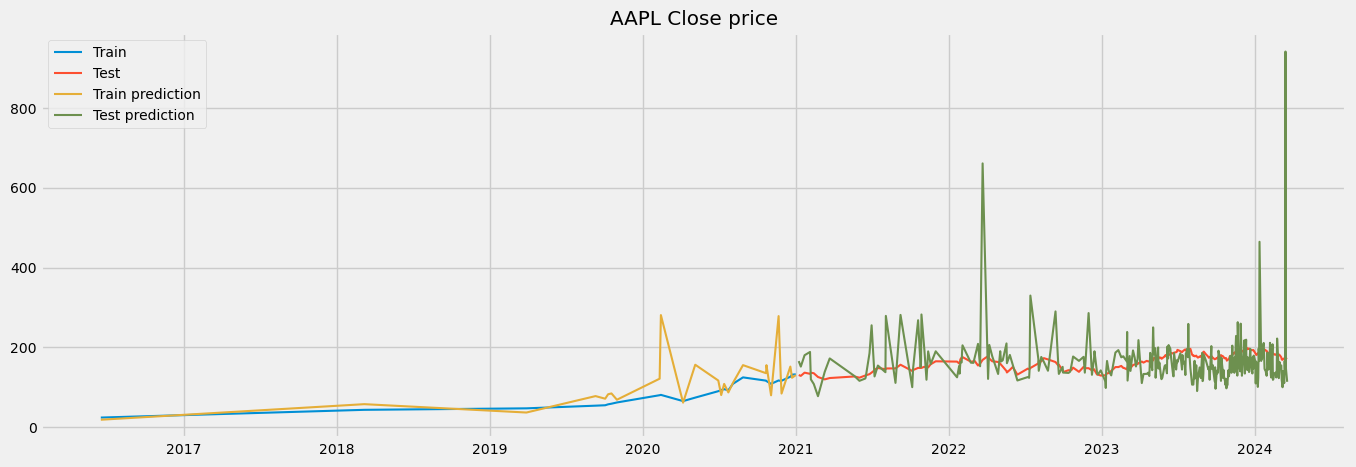

In [6]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['5ma','25ma', '50ma', '100ma', '200ma', 'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = SGDRegressor()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


Train error: 7.714376424358963
Test error: 34.8580321981583


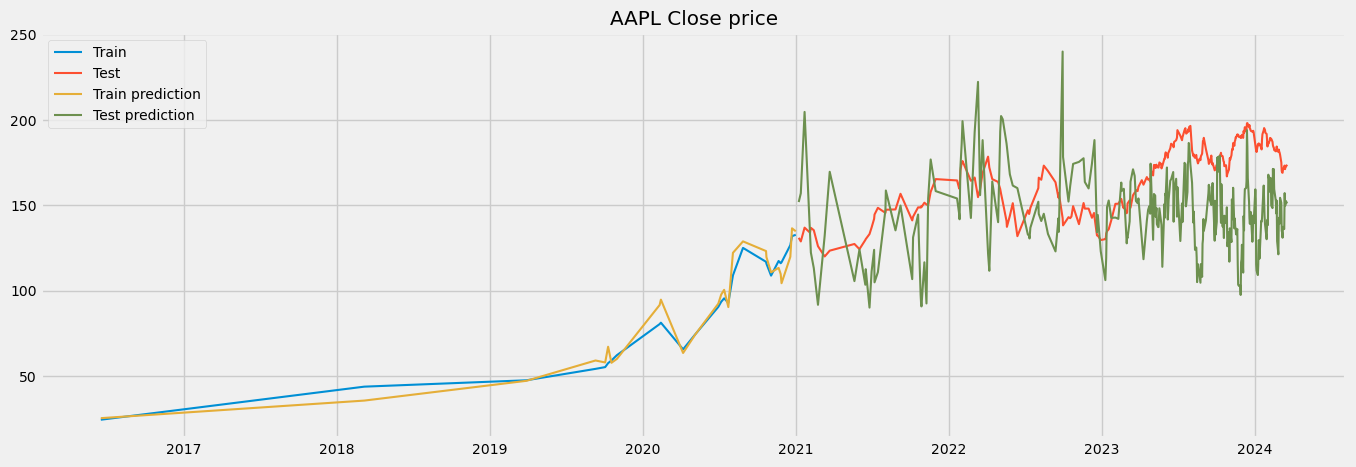

In [7]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = RandomForestRegressor(n_estimators=1000)
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


#XGBOOSt

Train error: 7.714376424358963
Test error: 34.8580321981583


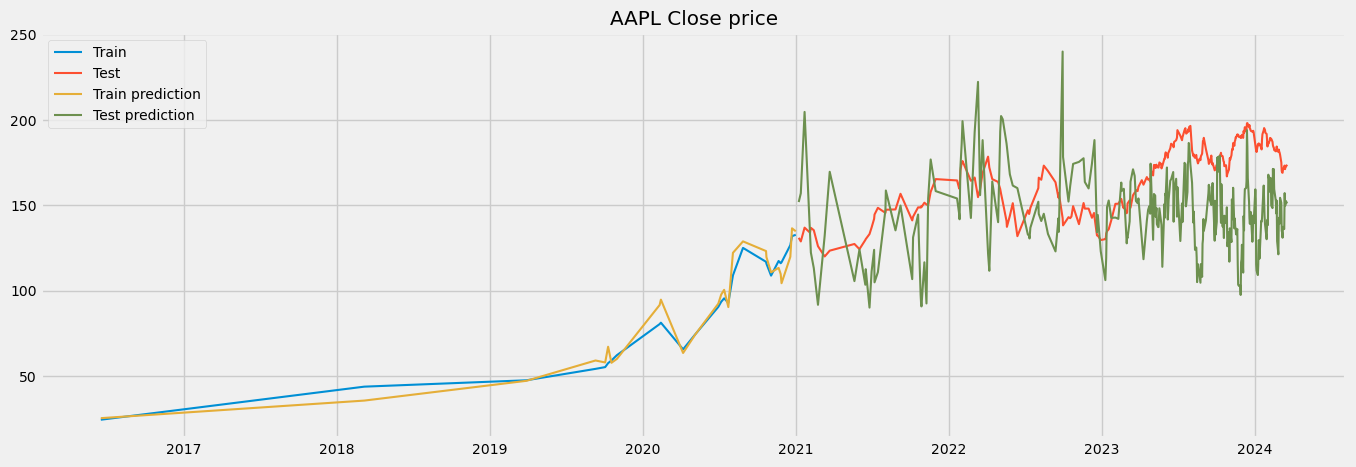

In [8]:
data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model = XGBRegressor(n_estimators=100)
model.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results

plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()


Epoch 1/100


381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47532.2812 - mae: 104.7319
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27742.7734 - mae: 86.2354
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20457.5703 - mae: 76.7704
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16133.2490 - mae: 66.8097
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11799.6309 - mae: 60.6493
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8393.7529 - mae: 56.0245
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7627.8677 - mae: 52.2551
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6658.4351 - mae: 49.8384
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6048.1826 - mae: 48.2623
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4712.4038 - mae: 43.8837
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4437.4932 - mae: 43.6145
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

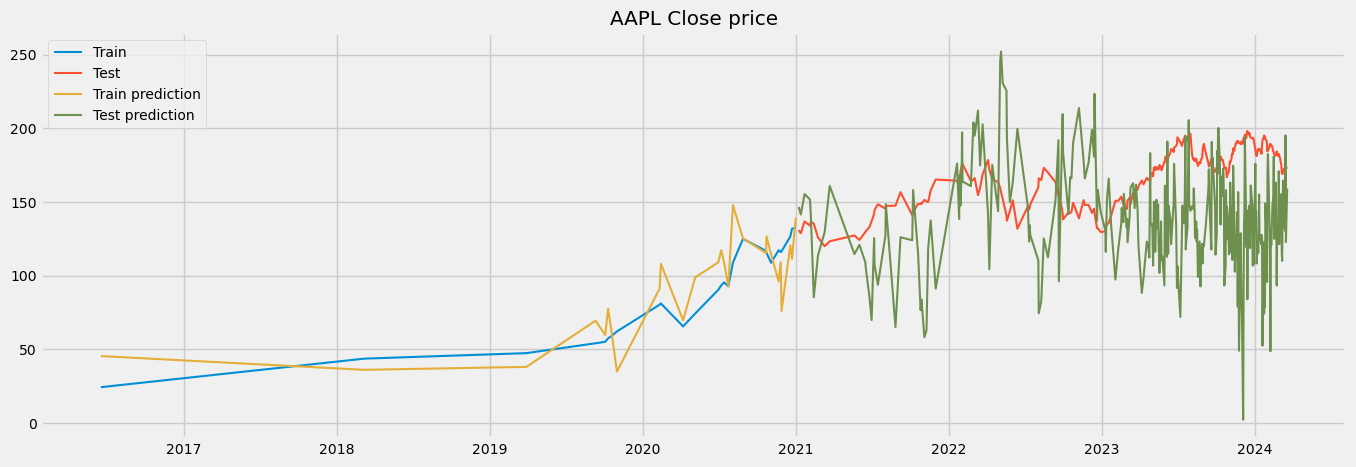

In [9]:
#predictict with a 1D Convolutional Neural Network
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers import MaxPooling1D, Dropout

data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

#reshape the data
X_train_reshaped = X_train_scaled.reshape(-21, 9, 1)

X_test_reshaped = X_test_scaled.reshape(-21, 9, 1)

#train the model

model = Sequential()
model.add(Conv1D(256, 2, activation='relu', input_shape=(9, 1)))
#dropout layer
model.add(Dropout(0.2))
model.add(Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D())


model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train_reshaped, y_train, epochs=100, verbose=1, batch_size=32)

#predict the close price
y_train_pred = model.predict(X_train_reshaped)

y_test_pred = model.predict(X_test_reshaped)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'

plt.figure(figsize=(15, 5))

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()



Epoch 1/100


381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - loss: 52580.0938 - mae: 106.1943
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 49121.4766 - mae: 98.3343
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 56474.2305 - mae: 97.0491
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 44139.1758 - mae: 95.0672
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 51413.6211 - mae: 97.0840
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 52311.6523 - mae: 95.7398
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 43319.2969 - mae: 92.7866
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 45148.4219 - mae: 93.7137
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 45052.8398 - mae: 95.0622
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 29880.4082 - mae: 83.8482
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 18911.4180 - mae: 73.9945
Epoch 12/100
381/381 ━━━━━━━━━

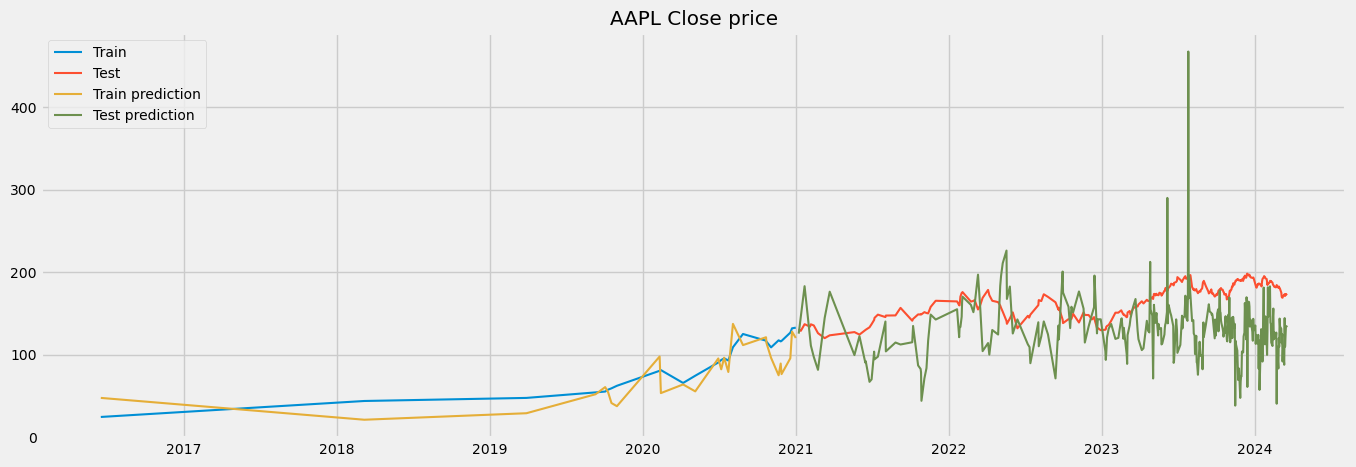

In [10]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data_train = data.loc[data.index < '2021-01-01']
data_test = data.loc[data.index >= '2021-01-01']

X_train = data_train[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_train = data_train['Close']

X_test = data_test[['5ma','25ma', '50ma', '100ma', '200ma',  'RSI', 'ATR', 'BBWIDTH', 'WilliamsR']]
y_test = data_test['Close']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for RNN
X_train_reshaped = X_train_scaled.reshape(-1, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 9, 1)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(9, 1)))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, verbose=1, batch_size=32)

# Predict the close price
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')

# Filter predictions and actual values by one symbol == 'AAPL'
plt.figure(figsize=(15, 5))

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()
